In [2]:
# Importar paquetes
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import scipy.optimize as opt
import math
import scipy.stats as stats



/Users/israelcastillo/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_closes(tickers, start_date=None, end_date=None, freq=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Frecuencia de muestreo por defecto (freq='d')
    # Importamos paquetes necesarios
    import pandas as pd
    pd.core.common.is_list_like = pd.api.types.is_list_like
    import pandas_datareader.data as web  
    # Creamos DataFrame vacío de precios, con el índice de las fechas
    closes = pd.DataFrame(columns = tickers, index=web.YahooDailyReader(symbols=tickers[0], start=start_date, end=end_date, interval=freq).read().index)
    # Agregamos cada uno de los precios con YahooDailyReader
    for ticker in tickers:
        df = web.YahooDailyReader(symbols=ticker, start=start_date, end=end_date, interval=freq).read()
        closes[ticker]=df['Adj Close']
    closes.index_name = 'Date'
    closes = closes.sort_index()
    return closes

In [13]:
# Información
ticker= ['^GSPC', 'MNKS.L', '^TNX'] 
start, end= '2016-04-21', '2020-04-23'

In [14]:
# Precios diarios
daily_closes = get_closes(ticker, start, end, freq='d') #d define es diario
daily_closes

,^GSPC,MNKS.L,^TNX
Date,,,
2016-04-21,2091.479980,427.884857,1.870
2016-04-22,2091.580078,424.284973,1.888
2016-04-25,2087.790039,425.984924,1.902
2016-04-26,2091.699951,426.984863,1.931
2016-04-27,2095.149902,429.584808,1.860
...,...,...,...
2020-04-17,2874.560059,890.000000,0.654
2020-04-20,2823.159912,898.000000,0.626
2020-04-21,2736.560059,867.000000,0.571


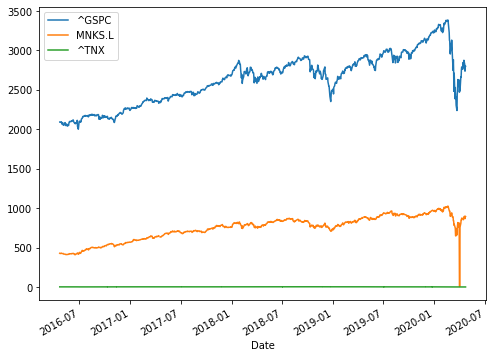

In [15]:
# Gráfico de histórico de precios diarios
daily_closes.plot(figsize=(8,6));

In [16]:
daily_logret = np.log(daily_closes/daily_closes.shift()).dropna()
daily_logret

,^GSPC,MNKS.L,^TNX
Date,,,
2016-04-22,0.000048,-0.008449,0.009580
2016-04-25,-0.001814,0.003999,0.007388
2016-04-26,0.001871,0.002345,0.015132
2016-04-27,0.001648,0.006071,-0.037462
2016-04-28,-0.009274,-0.005602,-0.011898
...,...,...,...
2020-04-17,0.026441,0.030807,0.071289
2020-04-20,-0.018043,0.008949,-0.043757
2020-04-21,-0.031155,-0.035131,-0.091961


In [17]:
# Podemos resumir en un DataFrame
daily_ret_summary = pd.DataFrame(index=['Media Diaria 2016-2020', 'Volatilidad Diaria 2016-2020'], columns=ticker)
daily_ret_summary.loc['Media Diaria 2016-2020']=round(daily_logret.mean(),4)
daily_ret_summary.loc['Volatilidad Diaria 2016-2020']=round(daily_logret.std(),4)
daily_ret_summary

,^GSPC,MNKS.L,^TNX
Media Diaria 2016-2020,0.0002,0.0008,-0.0012
Volatilidad Diaria 2016-2020,0.0123,0.2131,0.0354


In [18]:
# Resumen en base anual
annual_ret_summary = pd.DataFrame(index=['Media Anual 2016-2019', 'Vol Anual 2016-2019'], columns=ticker)
annual_ret_summary.loc['Media Anual 2016-2019']=round(daily_logret.mean()*252,2)
annual_ret_summary.loc['Vol Anual 2016-2019']=round(daily_logret.std()*np.sqrt(252),2)
annual_ret_summary

,^GSPC,MNKS.L,^TNX
Media Anual 2016-2019,0.06,0.19,-0.29
Vol Anual 2016-2019,0.2,3.38,0.56


In [19]:
cov = daily_logret.cov()
cov

,^GSPC,MNKS.L,^TNX
^GSPC,0.000151,0.000227,0.000199
MNKS.L,0.000227,0.045391,0.000198
^TNX,0.000199,0.000198,0.001250


In [20]:
rp=annual_ret_summary.iloc[0][1]
rm=annual_ret_summary.iloc[0][0]
sp=annual_ret_summary.iloc[1][1]
sm=annual_ret_summary.iloc[1][0]
rf=daily_closes.iloc[-1][2]/100 #Ya que los quotes del yield son en % - porcentaje
cov_p = cov.iloc[0][1]
beta = cov_p/(sm**2)
rp,rm,rf,sp,sm,cov_p,beta


(0.19,
 0.06,
 0.006130000352859497,
 3.38,
 0.2,
 0.00022746082860983149,
 0.005686520715245786)

In [21]:
P = ["MNSK.L"]
benchmarks = pd.DataFrame(index=['Sharpe Anual 2016-2019', 'Treynor Anual 2016-2019', 'Jensen Anual 2016-2019', 'M2 Anual 2016-2019', 'T2 Anual 2016-2019'], columns=P)
benchmarks.loc['Sharpe Anual 2016-2019'] = round((rp-rf)/sp,4)
benchmarks.loc['Treynor Anual 2016-2019'] = round((rp-rf)/beta,4)
benchmarks.loc['Jensen Anual 2016-2019'] = rp - (rf+beta*(rm-rf))
benchmarks.loc['M2 Anual 2016-2019'] = rf*(1-(sm/sp)+rp*(sm/sp))
benchmarks.loc['T2 Anual 2016-2019'] = rp/beta-rm #Positivo ajustado al nivel de riesgo superaste al mercado
benchmarks

,MNSK.L
Sharpe Anual 2016-2019,0.0544
Treynor Anual 2016-2019,32.3344
Jensen Anual 2016-2019,0.183564
M2 Anual 2016-2019,0.0058362
T2 Anual 2016-2019,33.3523
